# *Using magnetograms from different providers*
***

This notebook gives examples of how magnetograms from other observatories can be used. First, magnetograms for CR2097 are loaded from different observatories. These resulting plots can be compared to those in [Riley et al (2014)](https://doi.org/10.1007/s11207-013-0353-1). Second, some basic processing is done on the maps, and the empirical model is computed for the magnetograms.

A complication arises when using synoptic as opposed to synchronic or daily maps: since the map is constructed from ~ a month  worth of data, there is no definite date attached to the magnetogram. However, EUHFORIA requires a date to be attached to the magnetogram, since that date is used to distinguish times in the future (the forecast for which $t>0$) from those in the past. When using CR synoptic maps, there is thus some freedom in which time to choose. Here we set simpy the date of the map to be that of the middle of the CR.

To do:
   * Test HMI hourly maps
   * Add SOLIS, Kitt Peak, WSO

In [1]:
import copy
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sunpy
import sunpy.map
import sunpy.util.net

In [3]:
import astropy.units as units

In [4]:
import euhforia.core.map
import euhforia.plot.synoptic

In [5]:
# NOTE: You will need to use sunpy 0.7.9 to get this to work
print(sunpy.__version__)

0.7.9


Specify date to attach to synoptic magnetograms

In [6]:
date = datetime.datetime(2010, 6, 2, 4, 0)

In [7]:
print(sunpy.sun.carrington_rotation_number(date))

2097.50000794


## MWO

Data from the [Mt. Wilson observatory](http://obs.astro.ucla.edu/intro.html) is found at

   * ftp://howard.astro.ucla.edu/pub/obs/synoptic_charts/fits/
   for synoptic (CR) maps
   * ftp://howard.astro.ucla.edu/pub/obs/fits/
   for daily maps (??)


Download data for CR2097:

In [8]:
mwo_remote_file = "ftp://howard.astro.ucla.edu/pub/obs/synoptic_charts/fits/MP05_5250078_50_C2097500_01.fits"

In [9]:
mwo_local_file = sunpy.util.net.download_file(mwo_remote_file, directory="./", overwrite=True)

Next, we create a SunPy Map object from the file. In the process, the meta data of the file is corrected.

In [10]:
mwo_map = sunpy.map.Map(mwo_local_file)

mwo_map.meta['detector'] = 'MWO'
mwo_map.meta['ctype1'] = "CRLN-CAR"
mwo_map.meta['ctype2'] = "CRLT-CAR"
mwo_map.meta['cunit1'] = 'deg'
mwo_map.meta['cunit2'] = 'deg'
    
mwo_map.meta["CDELT2"] = 180.0/512.0 # More accurate versions of those provided in D(X/Y)B_IMG
mwo_map.meta["CDELT1"] = 360.0/971.0 

mwo_map.meta["CRLN_OBS"] = sunpy.sun.heliographic_solar_center(date)[0].to(units.deg)
mwo_map.meta["CRLT_OBS"] = sunpy.sun.heliographic_solar_center(date)[1].to(units.deg)
mwo_map.meta["DSUN_OBS"] = sunpy.sun.sunearth_distance(date).to(units.m)

mwo_map.meta['crval1'] = mwo_map.meta['cenlon']
mwo_map.meta['crval2'] = 0.0
mwo_map.meta['crpix1'] = mwo_map.meta['x0']
mwo_map.meta['crpix2'] = mwo_map.meta['y0']

mwo_map.meta["DATE-OBS"] = date.strftime("%Y-%m-%dT%H:%M:%S")
mwo_map.meta["DATE"]     = date.strftime("%Y-%m-%dT%H:%M:%S")

Plot the map. This can be compared to Figure 2 in Riley, although the latter is plotted using CEA projection.

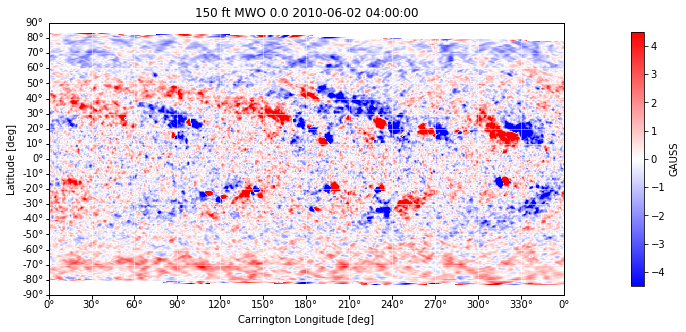

In [11]:
mwo_map.plot_settings["norm"] = plt.Normalize(-4.5, 4.5)
mwo_map.plot_settings["cmap"] = "bwr"
fig, ax = euhforia.plot.synoptic.plot(mwo_map);

Note the missing data in the polar regions. Here we simply set missing data to zero...

In [12]:
mwo_map.data[np.isnan(mwo_map.data)] = 0.0

## MDI

Data can be downloaded from the [Stanford MDI page](http://soi.stanford.edu/magnetic/index6.html)

In [13]:
mdi_remote_file = \
    "http://soi.stanford.edu/magnetic/synoptic/carrot/M_Corr/synop_Mr_0.polfil.2097.fits"

In [14]:
mdi_local_file = sunpy.util.net.download_file(mdi_remote_file, directory="./", overwrite=True)

The fits file cannot be loaded directly as a map due to faulty meta data

In [15]:
mdi_fits = sunpy.io.read_file(mdi_local_file)

In [16]:
data = np.asarray(mdi_fits[0][0], dtype=np.float64)
meta = dict(mdi_fits[0][1])

Fix the problematic entry

In [17]:
meta["R_SUN"] = sunpy.sun.constants.radius.value

Now we can create the map

In [18]:
mdi_map = sunpy.map.Map(data, meta)

In [19]:
mdi_map.meta['ctype1'] = "CRLN-CEA"
mdi_map.meta['ctype2'] = "CRLT-CEA"

mdi_map.meta['cunit1'] = "deg"
mdi_map.meta['cunit2'] = "deg"

mdi_map.meta['cdelt1'] = 0.1
mdi_map.meta['cdelt2'] = 2.0/(np.pi*mdi_map.meta['naxis2']/180.0)

mdi_map.meta['crpix1'] = 0.5*mdi_map.meta['naxis1'] + 0.5
mdi_map.meta['crpix2'] = 0.5*mdi_map.meta['naxis2'] + 0.5

mdi_map.meta['crval1'] = 180.0
mdi_map.meta['crval2'] = 0.0

mdi_map.meta["CRLN_OBS"] = sunpy.sun.heliographic_solar_center(date)[0].to(units.deg)
mdi_map.meta["CRLT_OBS"] = sunpy.sun.heliographic_solar_center(date)[1].to(units.deg)
mdi_map.meta["DSUN_OBS"] = sunpy.sun.sunearth_distance(date).to(units.m)

mdi_map.meta["DATE-OBS"] = date.strftime("%Y-%m-%dT%H:%M:%S")
mdi_map.meta["DATE"]     = date.strftime("%Y-%m-%dT%H:%M:%S")

Plot

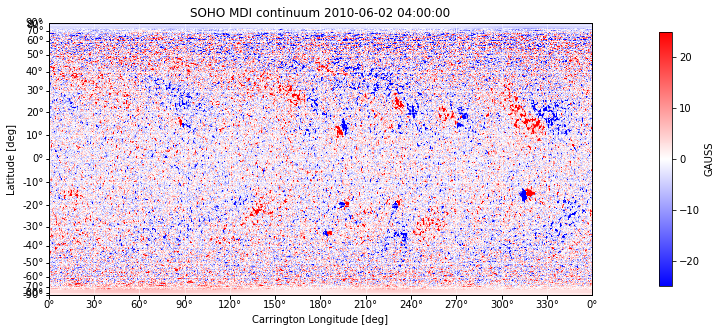

In [20]:
mdi_map.plot_settings["norm"] = plt.Normalize(-25, 25)
mdi_map.plot_settings["cmap"] = "bwr"
fig, ax = euhforia.plot.synoptic.plot(mdi_map);
ax.set_aspect(1.666)

In [34]:
mdi_map.data[np.isnan(mdi_map.data)] = 0.0

## HMI

HMI synoptic data products are available via [JSOC](http://jsoc.stanford.edu/HMI/LOS_Synoptic_charts.html). The 
CR maps are also available at
http://jsoc.stanford.edu/data/hmi/synoptic/ as well as at http://hmi.stanford.edu/data/synoptic.html. Hourly synoptic maps are only (?) available via the JSOC API

Download synoptic CR map (the reduced resolution version)

In [21]:
hmi_remote_file = "http://jsoc.stanford.edu/data/hmi/synoptic/hmi.Synoptic_Mr_small.2097.fits"

In [22]:
hmi_local_file = sunpy.util.net.download_file(hmi_remote_file, directory="./", overwrite=True)

Create map and correct the meta data:

In [23]:
hmi_map = sunpy.map.Map(hmi_local_file)

hmi_map.meta['ctype1'] = "CRLN-CEA"
hmi_map.meta['ctype2'] = "CRLT-CEA"

hmi_map.meta['CUNIT1'] = 'deg'
hmi_map.meta['CUNIT2'] = 'deg'

hmi_map.meta['CDELT1'] *= -1.0
hmi_map.meta['cdelt2'] = 2.0/(np.pi*hmi_map.meta['naxis2']/180.0)

hmi_map.meta['crpix1'] = 0.5*hmi_map.meta['naxis1'] + 0.5
hmi_map.meta['crpix2'] = 0.5*hmi_map.meta['naxis2'] + 0.5
hmi_map.meta['crval1'] = 180.0

hmi_map.meta["CRLN_OBS"] = sunpy.sun.heliographic_solar_center(date)[0].to(units.deg)
hmi_map.meta["CRLT_OBS"] = sunpy.sun.heliographic_solar_center(date)[1].to(units.deg)
hmi_map.meta["DSUN_OBS"] = sunpy.sun.sunearth_distance(date).to(units.m)

hmi_map.meta["DATE-OBS"] = date.strftime("%Y-%m-%dT%H:%M:%S")
hmi_map.meta["DATE"]     = date.strftime("%Y-%m-%dT%H:%M:%S")

/Users/jpomoell/miniconda/envs/euhforia/lib/python2.7/site-packages/sunpy/map/mapbase.py:675: Warning: Unknown value for CUNIT2
  warnings.warn("Unknown value for "+meta_property.upper(), Warning)


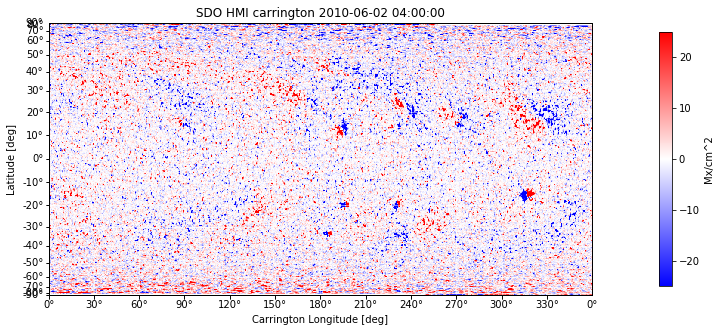

In [24]:
hmi_map.plot_settings["norm"] = plt.Normalize(-25, 25)
hmi_map.plot_settings["cmap"] = "bwr"
euhforia.plot.synoptic.plot(hmi_map);

In [35]:
hmi_map.data[np.isnan(hmi_map.data)] = 0.0

## GONG

For comparison, we load a daily GONG magnetogram

In [25]:
import euhforia.magnetogram.gong

In [26]:
gong_magnetogram_file \
    = euhforia.magnetogram.gong.retrieve(date, save_directory="./")

In [27]:
gong_map = euhforia.magnetogram.gong.read(gong_magnetogram_file)

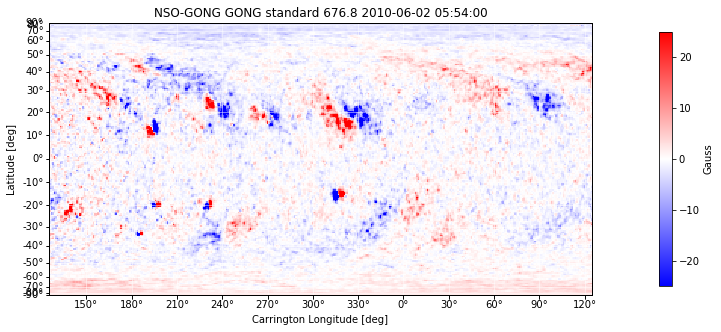

In [28]:
gong_map.plot_settings['norm'] = plt.Normalize(-25, 25)
gong_map.plot_settings['cmap'] = "bwr"
euhforia.plot.synoptic.plot(gong_map);

# Coronal model

Let's run the coronal model for the magnetograms above

In [29]:
import euhforia.corona.empirical
import scipy.ndimage

Create a container of magnetograms for easier looping

In [36]:
magnetograms = {"MWO"  : mwo_map,
                "GONG" : gong_map,
                "MDI"  : mdi_map,
                "HMI"  : hmi_map}

Run and save coronal model for each magnetogram. This will take some time..

In [37]:
results = dict()

In [38]:
for key in magnetograms.keys():
    
    print("Processing", key)

    # Get the magnetogram
    magnetogram = magnetograms[key]

    #
    # Instantiate coronal model
    #
    coronal_model = euhforia.corona.empirical.EmpiricalCoronalModel()

    # Initialize using default values
    coronal_model.initialize("../../run/corona_default.cfg")
    
    # Modify defaults
    coronal_model.config.set('Magnetogram', 'degrees_per_pixel', '2.0')
    coronal_model.config.set('HeliosphereBoundary', 'degrees_per_pixel', '4.0')
    
    #
    # Process the magnetogram
    #
    deg_per_pixel = coronal_model.config.getfloat('Magnetogram', 'degrees_per_pixel')
    
    # Regrid to the given resolution
    regridded_magnetogram \
        = euhforia.core.map.regrid(magnetogram, deg_per_pixel=deg_per_pixel)
    
    # Apply Gaussian smoothing to the data
    smoothed_magnetogram = copy.deepcopy(regridded_magnetogram)
    smoothed_magnetogram.data \
        = scipy.ndimage.gaussian_filter(smoothed_magnetogram.data, sigma=0.25)
    
    # Apply some scaling, here 1.01 just for demonstration 
    smoothed_magnetogram.data *= 1.01
    
    #
    # Compute coronal model
    #
    print("Computing", key)

    coronal_model.magnetogram = smoothed_magnetogram
    coronal_model.config.set('HeliosphereBoundary', 'output_file_name', './' + key + ".dat")
    
    coronal_model.compute()
    
    #
    # Save result
    #
    results[key] = coronal_model

Processing MDI
Computing MDI
Processing GONG
Computing GONG
Processing MWO
Computing MWO
Processing HMI
Computing HMI


## Plot resulting solar wind speed at 0.1 AU

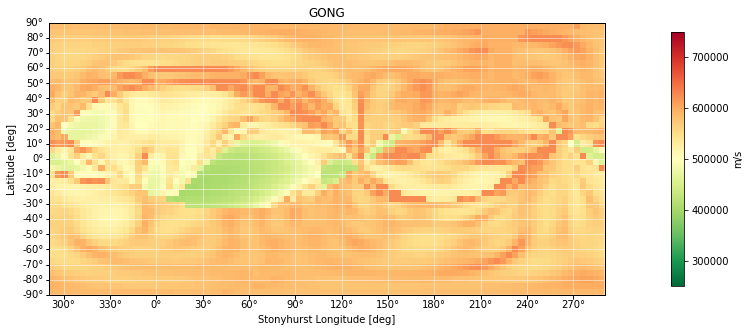

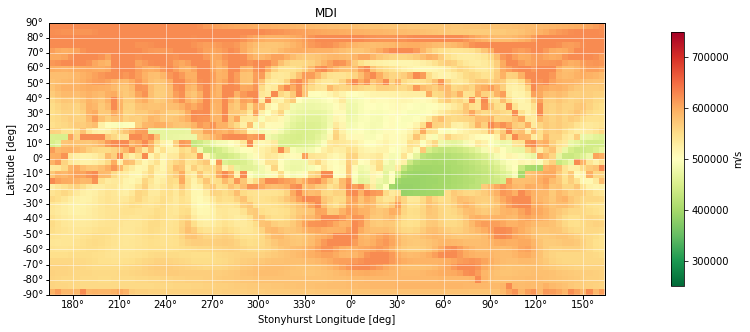

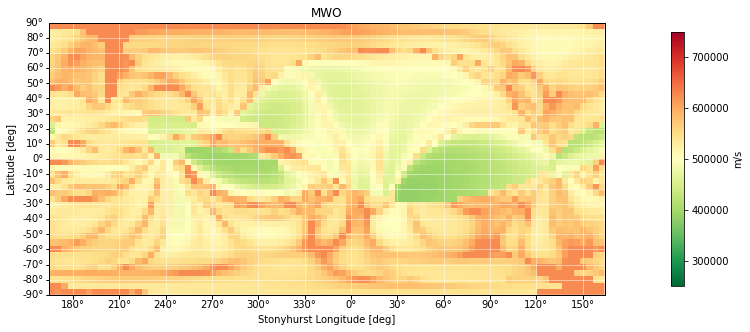

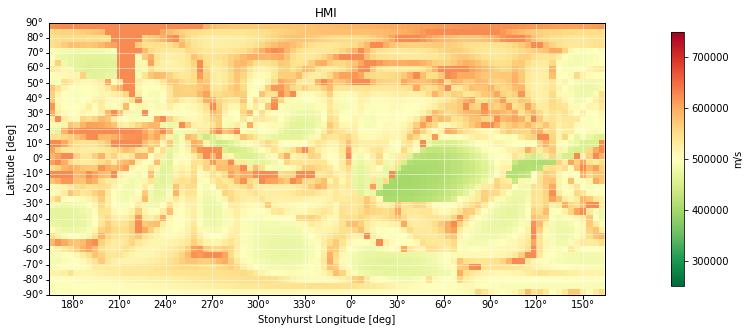

In [42]:
for key in results.keys():
    
    m = results[key].heliospheric_boundary["vr"]
    
    m.plot_settings["norm"] = plt.Normalize(250e3, 750e3)
    m.plot_settings["cmap"] = "RdYlGn_r"
    
    fig, ax = euhforia.plot.synoptic.plot(m);
    
    ax.set_title(key)

***